In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")


from hh_parser import url_builder
from hh_parser import hh_parse
from hh_parser import get_csv

In [2]:
# user-agent necessary to scrap the data
headers1 = {'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36'}

In [3]:
# in order for a search to work the search words should be separated by "+" sign
def search_word(word):
    word_split = word.split()
    result = '+'.join(word_split)
    return result

In [4]:
search_word = search_word('анализ данных')

In [5]:
# hh.ru search by the search word
url = url_builder(area=2, search_word=search_word)

In [6]:
jobs = hh_parse(url, headers1, 0)

13
20
31
37
47
57
70
81
94
101
108
118
129
139
148
161
162
DONE


In [7]:
get_csv(jobs)

In [8]:
df = pd.DataFrame(data = jobs)
df.head()

,title,href,company,description,salary
0,Аналитик,https://spb.hh.ru/vacancy/54869344?from=vacanc...,Точка,Помогать команде принимать решения на основе д...,до 240 000 руб.
1,Аналитик данных,https://spb.hh.ru/vacancy/53491771?from=vacanc...,Profilance Group (ИП Страмоусов Марк Петрович),Составлять гипотезы для улучшения определенных...,80 000 – 90 000 руб.
2,Продуктовый аналитик,https://spb.hh.ru/vacancy/54869038?from=vacanc...,Siberian Wellness,...продуктовых/маркетинговых/бизнес показателе...,200 000 – 250 000 руб.
3,Аналитик,https://spb.hh.ru/vacancy/53483652?from=vacanc...,Важная рыба,...и анализа коммерческой отчетности по заказа...,80 000 – 120 000 руб.
4,Инженер по обработке данных,https://spb.hh.ru/vacancy/54896574?from=vacanc...,ООО Профискетч,Разработка моделей данных. Описание требований...,60 000 – 70 000 руб.


In [9]:
df.shape

(162, 5)

OK, data was acquired

In order to analyze the salary I need to parse this column into min and max salary borders and the currency.

I will do it in a function below

In [10]:
def salary_parse(salary):
    split_salary = str(salary).split()[0:-4]
    split_salary.remove('salary')
    
    currencies = ['руб.', 'USD', 'EUR']
    
    for c in currencies:
        if c in split_salary:
            if 'от' in split_salary:
                split_salary.remove(c)
                split_salary.remove('от')
                min_salary = int(split_salary[0] + split_salary[1])
                return pd.Series((min_salary, np.nan, c))

            elif 'до' in split_salary:
                split_salary.remove(c)
                split_salary.remove('до')
                max_salary = int(split_salary[0] + split_salary[1])
                return pd.Series((np.nan, max_salary, c))
            else:
                split_salary.remove(c)
                split_salary.remove('–')        
                min_salary = int(split_salary[0] + split_salary[1])
                max_salary = int(split_salary[2] + split_salary[3])
                return pd.Series((min_salary, max_salary, c))

In [11]:
df[['min_salary', 'max_salary', 'currency']] = df[['salary']].apply(salary_parse, axis=1)

In [12]:
df.head()

,title,href,company,description,salary,min_salary,max_salary,currency
0,Аналитик,https://spb.hh.ru/vacancy/54869344?from=vacanc...,Точка,Помогать команде принимать решения на основе д...,до 240 000 руб.,NaN,240000.0,руб.
1,Аналитик данных,https://spb.hh.ru/vacancy/53491771?from=vacanc...,Profilance Group (ИП Страмоусов Марк Петрович),Составлять гипотезы для улучшения определенных...,80 000 – 90 000 руб.,80000.0,90000.0,руб.
2,Продуктовый аналитик,https://spb.hh.ru/vacancy/54869038?from=vacanc...,Siberian Wellness,...продуктовых/маркетинговых/бизнес показателе...,200 000 – 250 000 руб.,200000.0,250000.0,руб.
3,Аналитик,https://spb.hh.ru/vacancy/53483652?from=vacanc...,Важная рыба,...и анализа коммерческой отчетности по заказа...,80 000 – 120 000 руб.,80000.0,120000.0,руб.
4,Инженер по обработке данных,https://spb.hh.ru/vacancy/54896574?from=vacanc...,ООО Профискетч,Разработка моделей данных. Описание требований...,60 000 – 70 000 руб.,60000.0,70000.0,руб.


Now I want to know how many salaries in each currency do I have.

I'll write a function to get this data

In [13]:
def currency_split(df, chart=False):
    currencies = df['currency'].unique()
    for c in currencies:
        offers_number = df[df['currency']==c].shape[0]
        print('Number of positions with the salary in '+c+ ' — '+ str(offers_number))
        
    if chart is True:
        print()
        ax = sns.barplot(data = df.groupby('currency').count().title.reset_index(), x='currency', y = 'title')
        ax.set_ylabel('Positions')
        plt.title('How many salaries in each currency are presented in the dataset', fontsize=15)

Number of positions with the salary in руб. — 161
Number of positions with the salary in EUR — 1



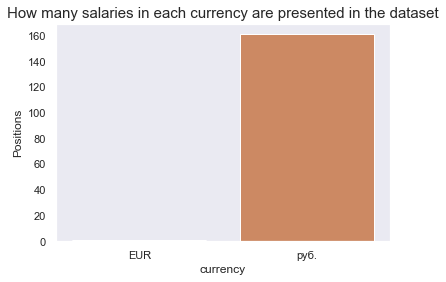

In [14]:
currency_split(df, chart=True)

I notice that not all positions mentioned both min and max salary borders.

Let's take a closer look to understand how the IT recruiters usually specify expected salaries.

In [15]:
def min_max_borders_check(df, chart=False):
    both_borders = df.dropna().shape[0]
    lower_border = df[df['max_salary'].isna()].shape[0]
    upper_border = df[df['min_salary'].isna()].shape[0]
    print('Number of positions with both min and max borders:', both_borders)
    print('Number of positions with only min salary:', lower_border)
    print('Number of positions with only max salary:', upper_border)

    if chart is True:
        data_dict = {'Both borders': [both_borders], 'Only min border': [lower_border], 'Only max border': [upper_border]}
        data = pd.DataFrame.from_dict(data_dict, orient='index').reset_index()
        
        print()
        ax = sns.barplot(data = data, x='index', y = 0)
        ax.set_xlabel('What border is included in the position description')
        ax.set_ylabel('Positions')
        plt.title('Positions based on the min and max salary borders in the description', fontsize=15)

I believe that rubble and USD/EUR positions should be analyzed separately, thus I will only focus on RUB positions right now

In [16]:
df_rub = df[df['currency'] == 'руб.']

Number of positions with both min and max borders: 76
Number of positions with only min salary: 70
Number of positions with only max salary: 15



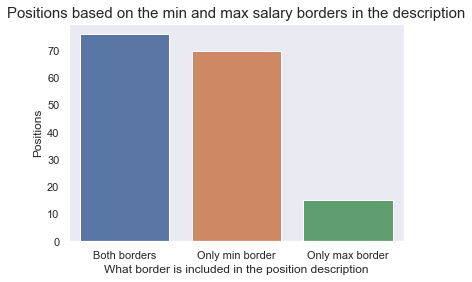

In [17]:
min_max_borders_check(df_rub, chart=True)

Here are some examples of positions of all 3 types

In [18]:
df.dropna().iloc[:3]

,title,href,company,description,salary,min_salary,max_salary,currency
1,Аналитик данных,https://spb.hh.ru/vacancy/53491771?from=vacanc...,Profilance Group (ИП Страмоусов Марк Петрович),Составлять гипотезы для улучшения определенных...,80 000 – 90 000 руб.,80000.0,90000.0,руб.
2,Продуктовый аналитик,https://spb.hh.ru/vacancy/54869038?from=vacanc...,Siberian Wellness,...продуктовых/маркетинговых/бизнес показателе...,200 000 – 250 000 руб.,200000.0,250000.0,руб.
3,Аналитик,https://spb.hh.ru/vacancy/53483652?from=vacanc...,Важная рыба,...и анализа коммерческой отчетности по заказа...,80 000 – 120 000 руб.,80000.0,120000.0,руб.


In [19]:
df[df['max_salary'].isna()].iloc[:3]

,title,href,company,description,salary,min_salary,max_salary,currency
5,Аналитик данных (data analyst),https://spb.hh.ru/vacancy/54721740?from=vacanc...,ООО Финансово-правовой альянс,"Работа со множеством источников данных: сбор, ...",от 120 000 руб.,120000.0,NaN,руб.
7,Аналитик БД/ SQL разработчик,https://spb.hh.ru/vacancy/50511711?from=vacanc...,BIV,...данных (DWH). Наращивание функциональности ...,от 140 000 руб.,140000.0,NaN,руб.
14,Бизнес-аналитик (финансовый и бухгалтерский учет),https://spb.hh.ru/vacancy/54883406?from=vacanc...,Франчайзинговая розничная сеть Галамарт,Описание бизнес-функциональный требований. Раз...,от 150 000 руб.,150000.0,NaN,руб.


In [20]:
df[df['min_salary'].isna()].iloc[:3]

,title,href,company,description,salary,min_salary,max_salary,currency
0,Аналитик,https://spb.hh.ru/vacancy/54869344?from=vacanc...,Точка,Помогать команде принимать решения на основе д...,до 240 000 руб.,NaN,240000.0,руб.
9,Старший аналитик,https://spb.hh.ru/vacancy/54927892?from=vacanc...,РОСЭЛ,Расчет показателей на основе анализа статистик...,до 90 000 руб.,NaN,90000.0,руб.
15,Системный аналитик,https://spb.hh.ru/vacancy/54782926?from=vacanc...,Enjoypro,"Система для автоматизация, расчета налоговых р...",до 180 000 руб.,NaN,180000.0,руб.


OK, let's focus now on the salaries.

In [21]:
print('Mean min salary is', round(df_rub['min_salary'].mean()), 'rub')
print('Mean max salary is', round(df_rub['max_salary'].mean()), 'rub')

Mean min salary is 81351 rub
Mean max salary is 119085 rub


Let's vizualize the salaries borders distributions

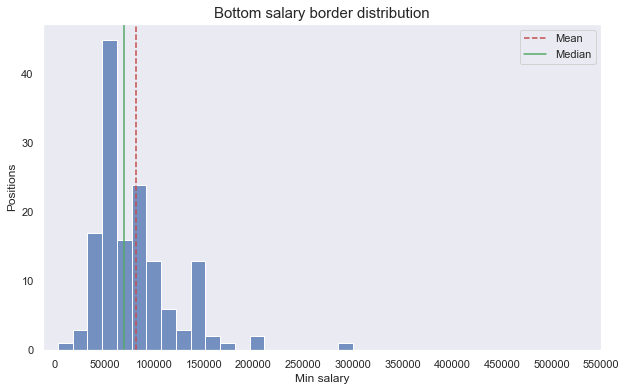

In [22]:
# min salary distributions
mean = df_rub['min_salary'].mean()
median = df_rub['min_salary'].median()

fig, ax = plt.subplots(figsize = (10,6))
ax = sns.histplot(data=df['min_salary'], bins=20)
ax.axvline(mean, color='r', linestyle='--', label="Mean")
ax.axvline(median, color='g', linestyle='-', label="Median")

ax.set_xticks(range(0, 600000, 50000))


ax.legend()
plt.title('Bottom salary border distribution', fontsize=15)
ax.set_xlabel('Min salary')
ax.set_ylabel('Positions')
plt.show()

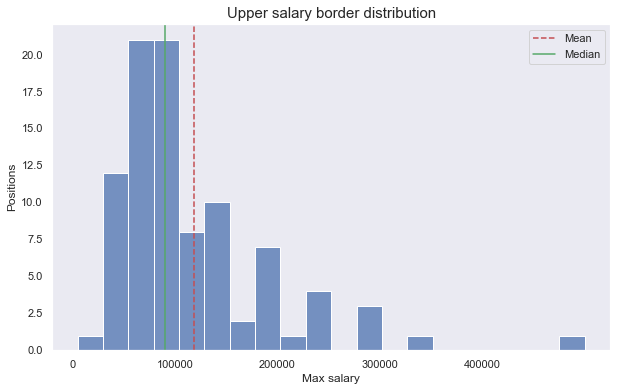

In [23]:
# Max salaries distrubtions
mean = df_rub['max_salary'].mean()
median = df_rub['max_salary'].median()


fig, ax = plt.subplots(figsize = (10,6))
ax = sns.histplot(data=df['max_salary'], bins=20)
ax.axvline(mean, color='r', linestyle='--', label="Mean")
ax.axvline(median, color='g', linestyle='-', label="Median")

ax.set_xticks(range(0, int(df_rub['max_salary'].max()), 100000))

ax.legend()
plt.title('Upper salary border distribution', fontsize=15)
ax.set_xlabel('Max salary')
ax.set_ylabel('Positions')
plt.show()

Based on the charts above we can see that most of the salary borders are located on the left side of the chart — unusually high salary borders look like outliers.

Interesting to note that on average min and max borders lie at around 90k — 110k mark

I want to calculate the mean and the median salary of the Analytis specialists. But in order to do it I need to know both bottom and upper borders of their salaries.

About half of positions are missing this data. In order to get it I will calculate how on average min salary is different from max salary.

Using this coefficient I will be able to approximate missing borders for the rest of the positions.

In [24]:
# df contains only rub jobs with both salary borders
df_rub_drop = df_rub.dropna()

In [25]:
df_rub_drop.head()

,title,href,company,description,salary,min_salary,max_salary,currency
1,Аналитик данных,https://spb.hh.ru/vacancy/53491771?from=vacanc...,Profilance Group (ИП Страмоусов Марк Петрович),Составлять гипотезы для улучшения определенных...,80 000 – 90 000 руб.,80000.0,90000.0,руб.
2,Продуктовый аналитик,https://spb.hh.ru/vacancy/54869038?from=vacanc...,Siberian Wellness,...продуктовых/маркетинговых/бизнес показателе...,200 000 – 250 000 руб.,200000.0,250000.0,руб.
3,Аналитик,https://spb.hh.ru/vacancy/53483652?from=vacanc...,Важная рыба,...и анализа коммерческой отчетности по заказа...,80 000 – 120 000 руб.,80000.0,120000.0,руб.
4,Инженер по обработке данных,https://spb.hh.ru/vacancy/54896574?from=vacanc...,ООО Профискетч,Разработка моделей данных. Описание требований...,60 000 – 70 000 руб.,60000.0,70000.0,руб.
6,Аналитик данных,https://spb.hh.ru/vacancy/54724344?from=vacanc...,ООО СРО-Экспертиза,Составлять гипотезы для улучшения определенных...,60 000 – 70 000 руб.,60000.0,70000.0,руб.


In [26]:
salary_diff = (df_rub_drop['max_salary'] - df_rub_drop['min_salary']) / df_rub_drop['max_salary']

salary_diff_mean = round(salary_diff.mean(), 3)
print('On average minimum salary is {:.1%} less compared to the max salary'.format(salary_diff_mean))

On average minimum salary is 27.0% less compared to the max salary


All right, let's use this knowledge to fill in the missing values with synthetic data

In [27]:
# a separate dataframe with synthetic salary data
df_rub_synth = df_rub.copy()

In [28]:
# for data with missing max salary fill in the max salary using formula 
# max_salary = min_salary / 1-  salary_diff_mean

df_rub_synth.loc[df_rub_synth['max_salary'].isna(), 'max_salary'] = \
df_rub_synth[df_rub_synth['max_salary'].isna()]['min_salary'] / (1-salary_diff_mean)

In [29]:
# for missing min values formula will be
# min_salary = max_salary * (1-salary_diff_mean)

df_rub_synth.loc[df_rub_synth['min_salary'].isna(), 'min_salary'] = \
df_rub_synth[df_rub_synth['min_salary'].isna()]['max_salary'] * (1-salary_diff_mean)

In [30]:
#round the numbers

df_rub_synth['max_salary'] = df_rub_synth['max_salary'].round()
df_rub_synth['min_salary'] = df_rub_synth['min_salary'].round()

Let's double check that all missing values were filled in and that the mean difference is correct.

In [31]:
min_max_borders_check(df_rub_synth)

Number of positions with both min and max borders: 161
Number of positions with only min salary: 0
Number of positions with only max salary: 0


In [32]:
salary_diff_synth = (df_rub_synth['max_salary'] - df_rub_synth['min_salary']) / df_rub_synth['max_salary']

salary_diff_synth_mean = round(salary_diff_synth.mean(), 3)
print('On average minimum salary is {:.1%} less compared to max salary'.format(salary_diff_synth_mean))

On average minimum salary is 27.0% less compared to max salary


In [33]:
df_rub_synth.head()

,title,href,company,description,salary,min_salary,max_salary,currency
0,Аналитик,https://spb.hh.ru/vacancy/54869344?from=vacanc...,Точка,Помогать команде принимать решения на основе д...,до 240 000 руб.,175200.0,240000.0,руб.
1,Аналитик данных,https://spb.hh.ru/vacancy/53491771?from=vacanc...,Profilance Group (ИП Страмоусов Марк Петрович),Составлять гипотезы для улучшения определенных...,80 000 – 90 000 руб.,80000.0,90000.0,руб.
2,Продуктовый аналитик,https://spb.hh.ru/vacancy/54869038?from=vacanc...,Siberian Wellness,...продуктовых/маркетинговых/бизнес показателе...,200 000 – 250 000 руб.,200000.0,250000.0,руб.
3,Аналитик,https://spb.hh.ru/vacancy/53483652?from=vacanc...,Важная рыба,...и анализа коммерческой отчетности по заказа...,80 000 – 120 000 руб.,80000.0,120000.0,руб.
4,Инженер по обработке данных,https://spb.hh.ru/vacancy/54896574?from=vacanc...,ООО Профискетч,Разработка моделей данных. Описание требований...,60 000 – 70 000 руб.,60000.0,70000.0,руб.


All right, the synthetic data is prepared.

Now I can estimate the mean salary of the Data analysis jobs on hh.ru

In [34]:
df_rub_synth['mean_salary'] = ((df_rub_synth['max_salary'] + df_rub_synth['min_salary']) / 2).round()

In [35]:
def mean_salary_chart(df, chart=False):
    mean = round(df['mean_salary'].mean())
    median = df['mean_salary'].median()
    Q1 = df['mean_salary'].quantile(q=0.25)
    Q3 = df['mean_salary'].quantile(q=0.75)

    print('Mean salary:', mean)
    print('Median salary:', median)
    print('25 percentile:', Q1)
    print('75 percentile:', Q3)
    print()
    
    if chart is True:
        fig, ax = plt.subplots(figsize = (10,6))
        ax = sns.histplot(data=df['mean_salary'], bins=20)
        ax.axvline(mean, color='r', linestyle='--', label="Mean", linewidth=3)
        ax.axvline(median, color='y', linestyle='--', label="Median", linewidth=3)
        ax.axvline(Q1, color='g', linestyle='-', label="1-Quantile", linewidth=3)
        ax.axvline(Q3, color='g', linestyle='-', label="3-Quantile", linewidth=3)


        ticks = range(0, int(df['mean_salary'].max()), 50000)
        ax.set_xticks(ticks)
        ax.set_xticklabels(i/1000 for i in ticks)

        ax.legend()
        plt.title(str('Distribution of the salaries in the field of: '+search_word), fontsize=15)
        ax.set_xlabel('Mean salary')
        ax.set_ylabel('Positions')
        plt.show()

Mean salary: 100076
Median salary: 82945.0
25 percentile: 65000.0
75 percentile: 118493.0



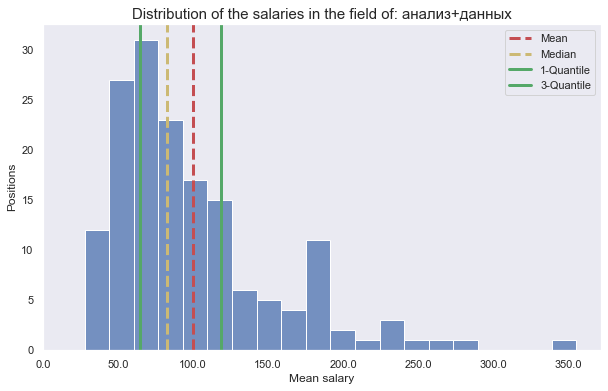

In [36]:
mean_salary_chart(df_rub_synth, chart=True)